In [246]:
from matplotlib import pyplot as plt 
import cv2
import numpy as np
import scipy.ndimage
import random
import torch.nn.init as init
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

In [242]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set environment variable
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

In [26]:
def generate_density_map(image, points, sigma=15):
    height, width = image.shape[:2]
    density_map = np.zeros((height, width), dtype=np.float32)

    for x, y in points:
        if x >= width or y >= height:  # Ignore points out of bounds
            continue
        density_map[y, x] = 1  # Mark head position

    # Apply Gaussian filter to simulate density
    density_map = scipy.ndimage.gaussian_filter(density_map, sigma=sigma, mode='constant')
    
    return density_map


In [251]:
def denormalize(tensor_img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor_img * std + mean

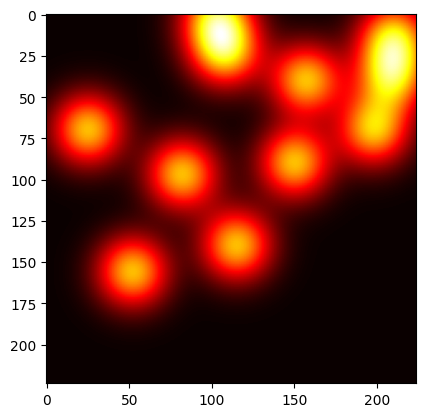

In [27]:
image = cv2.imread('Train_resized_2/img_0001_crop_0.jpg')
mat = scipy.io.loadmat('Train_resized_2/img_0001_crop_0.mat')
points = mat["annPoints"]
points = points.astype(int)

density_map = generate_density_map(image, points)
plt.imshow(density_map, cmap='hot')

In [247]:
class CrowdCounterResNet(nn.Module):
    def __init__(self):
        super(CrowdCounterResNet, self).__init__()

        # Load pretrained ResNet-18 and remove the classification layers
        resnet = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 512, 7, 7)

        # Decoder: Upsample from (7x7) → (224x224)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 7→14
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 14→28
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 28→56
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 56→112
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 112→224
            nn.ReLU()
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.decoder(x)
        return x



class CrowdCounterResNetWeights(nn.Module):
    def __init__(self):
        super().__init__()

        # Load pretrained ResNet-18 and remove the classification layers
        resnet = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 512, 7, 7)

        # Decoder: Upsample from (7x7) → (224x224)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 7→14
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 14→28
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 28→56
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 56→112
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 112→224
            nn.ReLU()
        )
        self._initialize_weights()  # <- He initialization here

    def _initialize_weights(self):
        for m in self.decoder:
            if isinstance(m, nn.ConvTranspose2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward(self, x):
        x = self.backbone(x)
        x = self.decoder(x)
        return x
    

class CrowdCounterResNet34Weights(nn.Module):
    def __init__(self):
        super().__init__()

        # Load pretrained ResNet-34 and remove the classification layers
        resnet = models.resnet34(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 512, 7, 7)

        # Decoder: Upsample from (7x7) → (224x224)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 7→14
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 14→28
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 28→56
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 56→112
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 112→224
            nn.ReLU()
        )
        self._initialize_weights()  # <- He initialization here

    def _initialize_weights(self):
        for m in self.decoder:
            if isinstance(m, nn.ConvTranspose2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward(self, x):
        x = self.backbone(x)
        x = self.decoder(x)
        return x
    

class CrowdCounterResNet50Weights(nn.Module):
    def __init__(self):
        super().__init__()

        # Load pretrained ResNet-50 and remove the classification layers
        resnet = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 512, 7, 7)

        # Decoder: Upsample from (7x7) → (224x224)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  
            nn.ReLU()
        )
        self._initialize_weights()  # <- He initialization here

    def _initialize_weights(self):
        for m in self.decoder:
            if isinstance(m, nn.ConvTranspose2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward(self, x):
        x = self.backbone(x)
        x = self.decoder(x)
        return x

In [157]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CrowdCounterResNet().to(device)
print(device)
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [156]:
class CrowdDataset(Dataset):
    def __init__(self, image_folder, density_map_folder, image_files, transform=None):
        self.image_folder = image_folder
        self.density_map_folder = density_map_folder
        self.image_files = image_files
        self.transform = transform

        # Default transforms (if none provided)
        if self.transform is None:
            self.transform = T.Compose([
                T.ToTensor(),  # Converts to [0,1] and (C,H,W)
                T.Normalize(
                    mean=[0.485, 0.456, 0.406],  # ImageNet mean
                    std=[0.229, 0.224, 0.225]    # ImageNet std
                )
            ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR -> RGB
        # Load density map
        density_map_name = img_path.replace('.jpg', '_density.npy').replace(
            self.image_folder, self.density_map_folder
        )
        density_map = np.load(density_map_name)  # (H, W)

        # Apply transforms to image
        if self.transform:
            image = self.transform(image)  # Now includes ToTensor() and Normalize

        # Convert density map to tensor
        density_map = torch.from_numpy(density_map).unsqueeze(0).float()  # (1, H, W)

        return image, density_map
    



In [158]:
train_resized_folder = "Train_resized_2"
train_density_folder = "Train_density_2"

train_image_paths = []
train_heatmap_paths = []

# Iterate over files in Train_resized folder
for file_name in os.listdir(train_resized_folder):
    if file_name.endswith(".jpg"):
        train_image_paths.append(os.path.join(train_resized_folder, file_name))

# Iterate over files in Train_density folder
for file_name in os.listdir(train_density_folder):
    if file_name.endswith(".npy"):
        train_heatmap_paths.append(os.path.join(train_density_folder, file_name))

print(f"Found {len(train_image_paths)} images and {len(train_heatmap_paths)} heatmaps.")


validation_resized_folder = "Validation_resized_2"
validation_density_folder = "Validation_density_2"
validation_image_paths = []
validation_heatmap_paths = []

# Iterate over files in Validation_resized folder
for file_name in os.listdir(validation_resized_folder):
    if file_name.endswith(".jpg"):
        validation_image_paths.append(os.path.join(validation_resized_folder, file_name))

# Iterate over files in Validation_density folder
for file_name in os.listdir(validation_density_folder):
    if file_name.endswith(".npy"):
        validation_heatmap_paths.append(os.path.join(validation_density_folder, file_name))

print(f"Found {len(validation_image_paths)} images and {len(validation_heatmap_paths)} heatmaps.")

Found 4804 images and 4804 heatmaps.
Found 668 images and 668 heatmaps.


In [159]:
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# normalize = T.Normalize(mean, std)

train_dataset = CrowdDataset(train_resized_folder, train_density_folder, train_image_paths)
validation_dataset = CrowdDataset(validation_resized_folder, validation_density_folder, validation_image_paths)

In [188]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-5, device='cuda', save_path='best_model.pth'):
    scale_factor = 100
    train_loss_list = []
    validation_loss_list = []

    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    best_val_loss = float('inf')
    best_epoch = -1

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, targets in train_loader:
            images = images.to(device)
            targets_scaled = targets * scale_factor
            targets_scaled = targets_scaled.to(device)

            optimizer.zero_grad()
            outputs_scaled = model(images)
            loss = criterion(outputs_scaled, targets_scaled)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_loss_list.append(avg_train_loss)
        print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.6f}")

        # Validation
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, targets in val_loader:
                    images = images.to(device)
                    targets_scaled = targets * scale_factor
                    targets_scaled = targets_scaled.to(device)
                    outputs_scaled = model(images)
                    loss = criterion(outputs_scaled, targets_scaled)
                    val_loss += loss.item() * images.size(0)

            avg_val_loss = val_loss / len(val_loader.dataset)
            validation_loss_list.append(avg_val_loss)
            print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.6f}")

            # Save the best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch + 1
                torch.save(model.state_dict(), save_path)
                print(f"Best model saved at epoch {best_epoch} with val loss {best_val_loss:.6f}")

    print(f"\nBest model was at epoch {best_epoch} with val loss {best_val_loss:.6f}")
    return model, train_loss_list, validation_loss_list, best_epoch


In [189]:
model = CrowdCounterResNetWeights()

# Assuming you have these ready
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)

trained_model, train_loss, validation_loss, best_epoch = train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-5, device=device)

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Training Loss: 0.068507
Epoch 1 Validation Loss: 0.065225
Best model saved at epoch 1 with val loss 0.065225
Epoch 2 Training Loss: 0.060575
Epoch 2 Validation Loss: 0.060106
Best model saved at epoch 2 with val loss 0.060106
Epoch 3 Training Loss: 0.056827
Epoch 3 Validation Loss: 0.061944
Epoch 4 Training Loss: 0.054003
Epoch 4 Validation Loss: 0.059595
Best model saved at epoch 4 with val loss 0.059595
Epoch 5 Training Loss: 0.052634
Epoch 5 Validation Loss: 0.058679
Best model saved at epoch 5 with val loss 0.058679
Epoch 6 Training Loss: 0.051150
Epoch 6 Validation Loss: 0.056909
Best model saved at epoch 6 with val loss 0.056909
Epoch 7 Training Loss: 0.050441
Epoch 7 Validation Loss: 0.057755
Epoch 8 Training Loss: 0.049495
Epoch 8 Validation Loss: 0.059788
Epoch 9 Training Loss: 0.048893
Epoch 9 Validation Loss: 0.058491
Epoch 10 Training Loss: 0.048748
Epoch 10 Validation Loss: 0.056316
Best model saved at epoch 10 with val loss 0.056316
Epoch 11 Training Loss: 0.04810

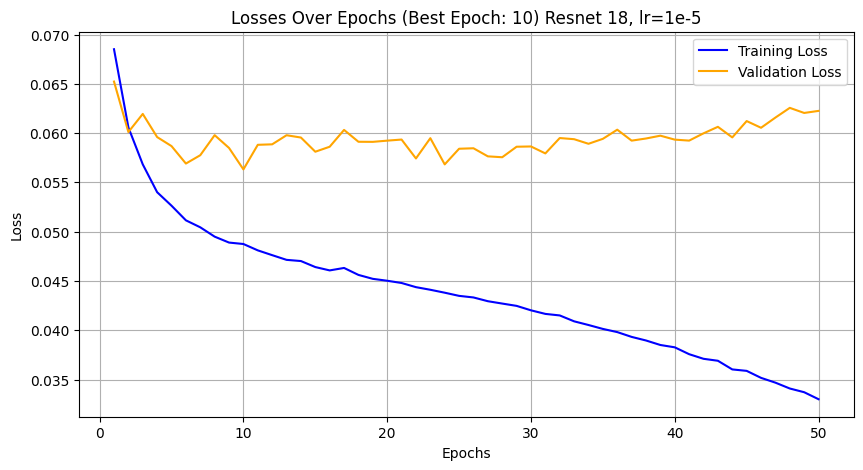

In [190]:
def plot_losses(train_loss, validation_loss, best_epoch, title):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue')
    plt.plot(epochs, validation_loss, label='Validation Loss', color='orange')
    plt.title('Losses Over Epochs' + f' (Best Epoch: {best_epoch})' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


plot_losses(train_loss, validation_loss, best_epoch, title=" Resnet 18, lr=1e-5")

In [119]:
trained_model = CrowdCounterResNet()
trained_model.load_state_dict(torch.load('ResNet18_1e-5.pth'))

<All keys matched successfully>

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted Count: 2.37, GT Count: 10.80
Predicted Max pixel value: 2.373173
Predicted Min pixel value: 2.373173
GT Max pixel value: 0.017684886
GT Min pixel value: 0.0


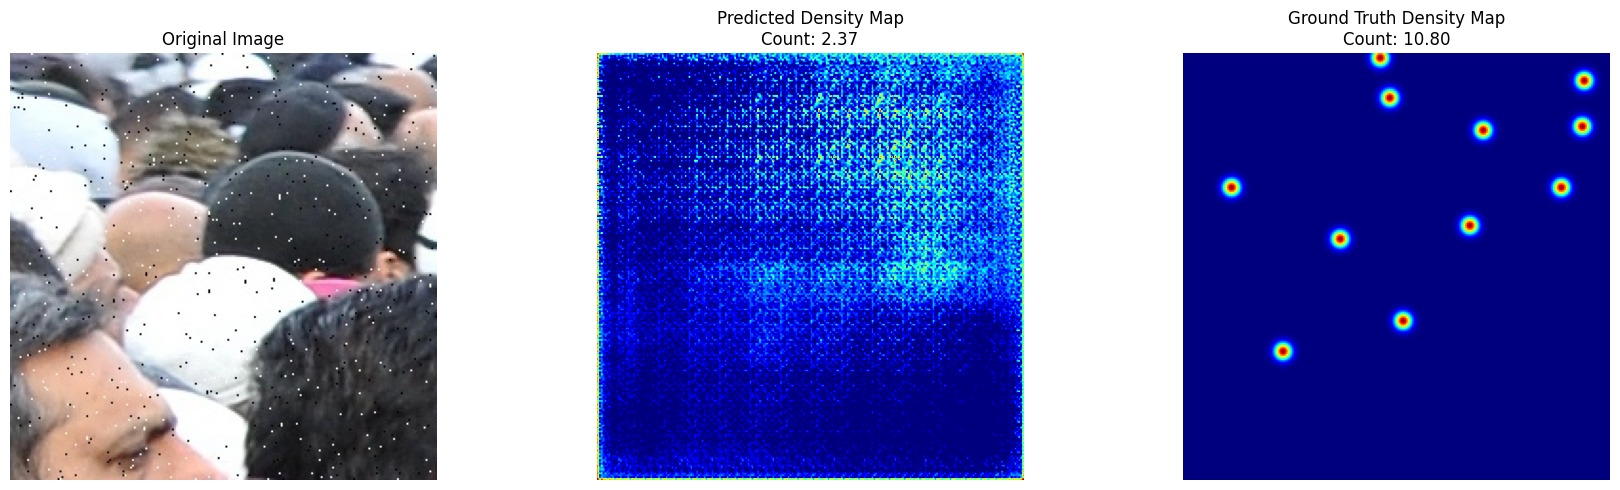

In [252]:
def visualize_output(model_, dataset, device='cuda', index=0):
    model_.eval()
    scale_factor = 100
    
    # Get a sample
    image, gt_density = dataset[index]
    image = denormalize(image)  # Denormalize the image for visualization
    gt_density_scaled = gt_density * scale_factor  # Scale the ground truth density map
    image = image.to(device).unsqueeze(0)  # Add batch dim
    gt_density_scaled = gt_density_scaled.squeeze().cpu().numpy()
    gt_density = gt_density.squeeze().cpu().numpy()  # Convert to numpy for visualization

    # Predict
    with torch.no_grad():
        output_scaled = model_(image)
        # output = F.interpolate(output, size=(224, 224), mode='bilinear', align_corners=False)
        output_scaled = output_scaled.squeeze().cpu().numpy()


    # Count predictions
    output = output_scaled / scale_factor  # Scale back the output
    predicted_count = output.sum()
    gt_count = gt_density.sum()

    print(f"Predicted Count: {predicted_count:.2f}, GT Count: {gt_count:.2f}")
    print("Predicted Max pixel value:", predicted_count.max())
    print("Predicted Min pixel value:", predicted_count.min())

    print("GT Max pixel value:", gt_density.max())
    print("GT Min pixel value:", gt_density.min())

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Original image
    axs[0].imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Predicted density map
    axs[1].imshow(output, cmap='jet')
    axs[1].set_title(f"Predicted Density Map\nCount: {predicted_count:.2f}")
    axs[1].axis('off')

    # Ground truth density map
    axs[2].imshow(gt_density, cmap='jet')
    axs[2].set_title(f"Ground Truth Density Map\nCount: {gt_count:.2f}")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


best_model_5 = CrowdCounterResNet()
best_model_5.load_state_dict(torch.load('ResNet18_1e-5.pth'))
best_model_5 = best_model_5.to(device)
visualize_output(best_model_5, train_dataset, device=device, index=0)

In [67]:
image, target = train_dataset[0]
print("Image stats:", image.mean(), image.std(), image.min(), image.max())


Image stats: tensor(0.4098) tensor(1.3722) tensor(-2.1179) tensor(2.6400)


Now we will try ResNet 18 backboned model with different learning rates

In [167]:
trained_model_3 = CrowdCounterResNetWeights()
trained_model_3, train_loss_3, validation_loss_3, best_epoch_3 = train_model(trained_model_3, train_loader, val_loader, num_epochs=50, lr=1e-3, device=device, save_path='ResNet18_1e-3.pth') 

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Training Loss: 0.073473
Epoch 1 Validation Loss: 0.072864
Best model saved at epoch 1 with val loss 0.072864
Epoch 2 Training Loss: 0.068337
Epoch 2 Validation Loss: 0.076229
Epoch 3 Training Loss: 0.063774
Epoch 3 Validation Loss: 0.065272
Best model saved at epoch 3 with val loss 0.065272
Epoch 4 Training Loss: 0.062702
Epoch 4 Validation Loss: 0.067909
Epoch 5 Training Loss: 0.061612
Epoch 5 Validation Loss: 0.076371
Epoch 6 Training Loss: 0.061849
Epoch 6 Validation Loss: 0.064712
Best model saved at epoch 6 with val loss 0.064712
Epoch 7 Training Loss: 0.060170
Epoch 7 Validation Loss: 0.065122
Epoch 8 Training Loss: 0.058567
Epoch 8 Validation Loss: 0.062351
Best model saved at epoch 8 with val loss 0.062351
Epoch 9 Training Loss: 0.058610
Epoch 9 Validation Loss: 0.061069
Best model saved at epoch 9 with val loss 0.061069
Epoch 10 Training Loss: 0.056981
Epoch 10 Validation Loss: 0.071867
Epoch 11 Training Loss: 0.057898
Epoch 11 Validation Loss: 0.070573
Epoch 12 Traini

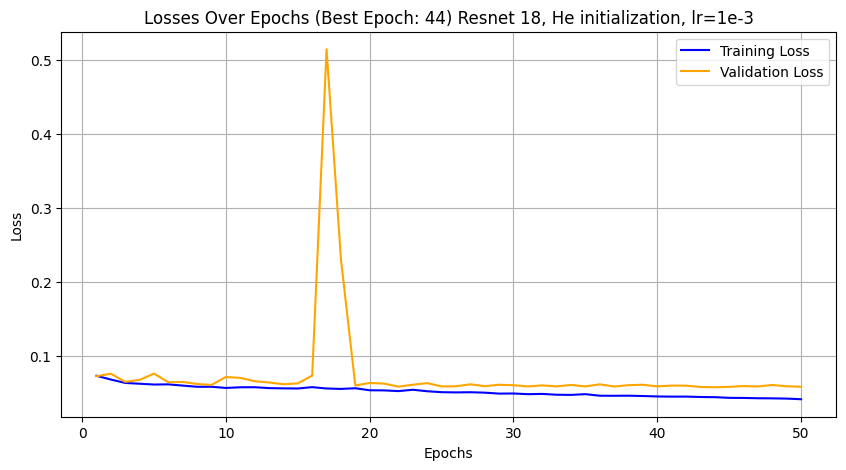

In [168]:
plot_losses(train_loss_3, validation_loss_3, best_epoch_3, title=" Resnet 18, He initialization, lr=1e-3")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted Count: 7.77, GT Count: 14.54
Predicted Max pixel value: 7.7728715
Predicted Min pixel value: 7.7728715
GT Max pixel value: 0.017684886
GT Min pixel value: 0.0


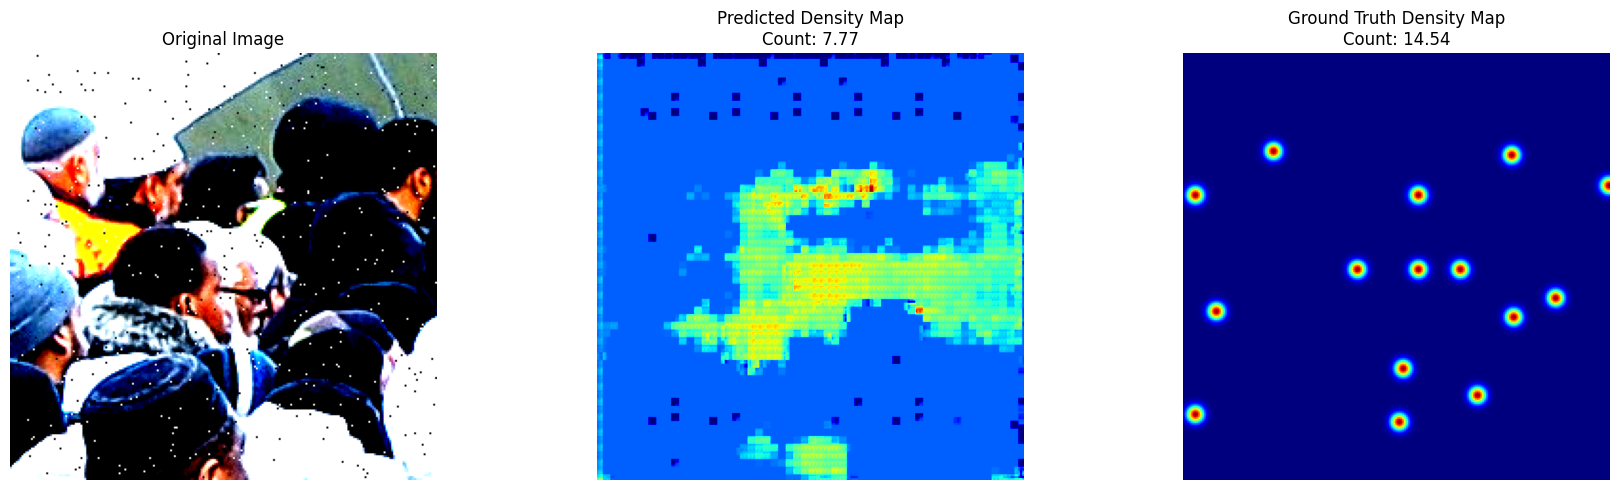

In [175]:
trained_model_3 = CrowdCounterResNetWeights()
trained_model_3.load_state_dict(torch.load('ResNet18_1e-3.pth'))
trained_model_3 = trained_model_3.to(device)
visualize_output(trained_model_3, train_dataset, device=device, index=3)

In [176]:
trained_model_4 = CrowdCounterResNetWeights()
trained_model_4, train_loss_4, validation_loss_4, best_epoch_4 = train_model(trained_model_4, train_loader, val_loader, num_epochs=50, lr=1e-4, device=device, save_path='ResNet18_1e-4.pth')

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Training Loss: 0.063573
Epoch 1 Validation Loss: 0.061379
Best model saved at epoch 1 with val loss 0.061379
Epoch 2 Training Loss: 0.058372
Epoch 2 Validation Loss: 0.060606
Best model saved at epoch 2 with val loss 0.060606
Epoch 3 Training Loss: 0.056621
Epoch 3 Validation Loss: 0.059327
Best model saved at epoch 3 with val loss 0.059327
Epoch 4 Training Loss: 0.054945
Epoch 4 Validation Loss: 0.063290
Epoch 5 Training Loss: 0.052536
Epoch 5 Validation Loss: 0.058623
Best model saved at epoch 5 with val loss 0.058623
Epoch 6 Training Loss: 0.051598
Epoch 6 Validation Loss: 0.061824
Epoch 7 Training Loss: 0.050527
Epoch 7 Validation Loss: 0.054273
Best model saved at epoch 7 with val loss 0.054273
Epoch 8 Training Loss: 0.050182
Epoch 8 Validation Loss: 0.062123
Epoch 9 Training Loss: 0.049016
Epoch 9 Validation Loss: 0.061060
Epoch 10 Training Loss: 0.048312
Epoch 10 Validation Loss: 0.058220
Epoch 11 Training Loss: 0.046765
Epoch 11 Validation Loss: 0.054965
Epoch 12 Traini

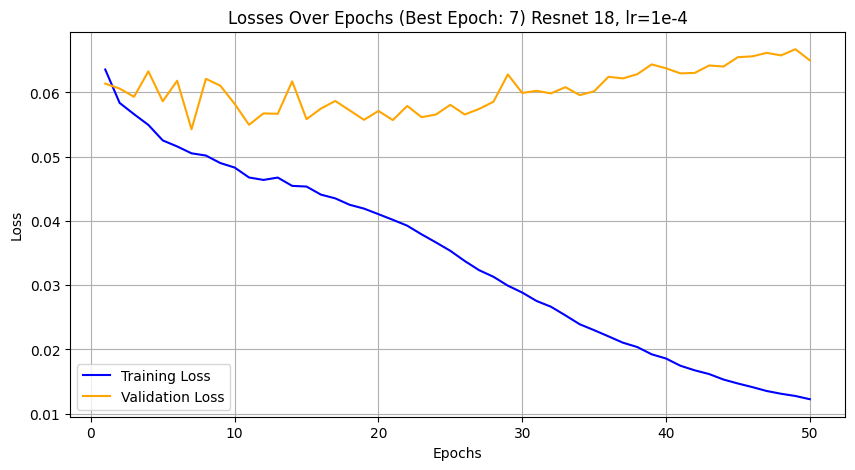

In [177]:
plot_losses(train_loss_4, validation_loss_4, best_epoch_4, title=" Resnet 18, lr=1e-4")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted Count: 8.05, GT Count: 14.54
Predicted Max pixel value: 8.049863
Predicted Min pixel value: 8.049863
GT Max pixel value: 0.017684886
GT Min pixel value: 0.0


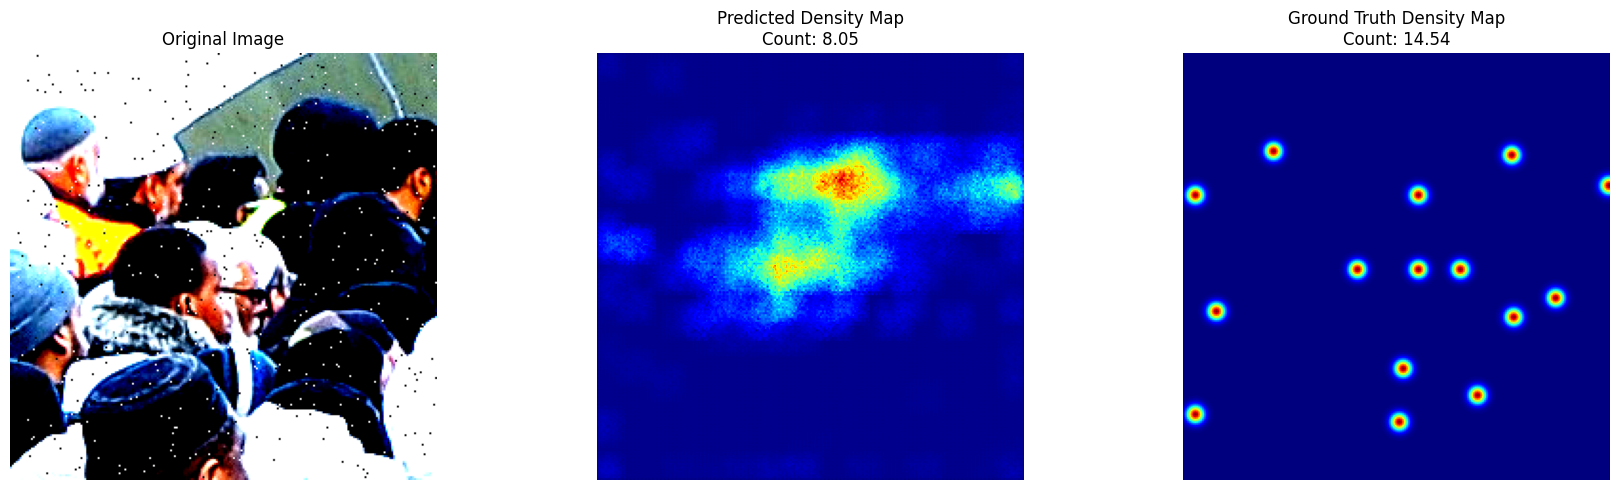

In [181]:
best_model_4 = CrowdCounterResNet()
best_model_4.load_state_dict(torch.load('ResNet18_1e-4.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model_4.to(device)
visualize_output(best_model_4, train_dataset, device=device, index=3)

Now Learning rate 1e-6

In [195]:
trained_model_6 = CrowdCounterResNetWeights()
trained_model_6, train_loss_6, validation_loss_6, best_epoch_6 = train_model(trained_model_6, train_loader, val_loader, num_epochs=50, lr=1e-6, device=device, save_path='ResNet18_1e-6.pth')

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Training Loss: 0.076687
Epoch 1 Validation Loss: 0.078688
Best model saved at epoch 1 with val loss 0.078688
Epoch 2 Training Loss: 0.071647
Epoch 2 Validation Loss: 0.072479
Best model saved at epoch 2 with val loss 0.072479
Epoch 3 Training Loss: 0.068571
Epoch 3 Validation Loss: 0.070644
Best model saved at epoch 3 with val loss 0.070644
Epoch 4 Training Loss: 0.066924
Epoch 4 Validation Loss: 0.069821
Best model saved at epoch 4 with val loss 0.069821
Epoch 5 Training Loss: 0.065377
Epoch 5 Validation Loss: 0.068448
Best model saved at epoch 5 with val loss 0.068448
Epoch 6 Training Loss: 0.064241
Epoch 6 Validation Loss: 0.067217
Best model saved at epoch 6 with val loss 0.067217
Epoch 7 Training Loss: 0.063527
Epoch 7 Validation Loss: 0.062825
Best model saved at epoch 7 with val loss 0.062825
Epoch 8 Training Loss: 0.062967
Epoch 8 Validation Loss: 0.064115
Epoch 9 Training Loss: 0.061805
Epoch 9 Validation Loss: 0.061073
Best model saved at epoch 9 with val loss 0.06107

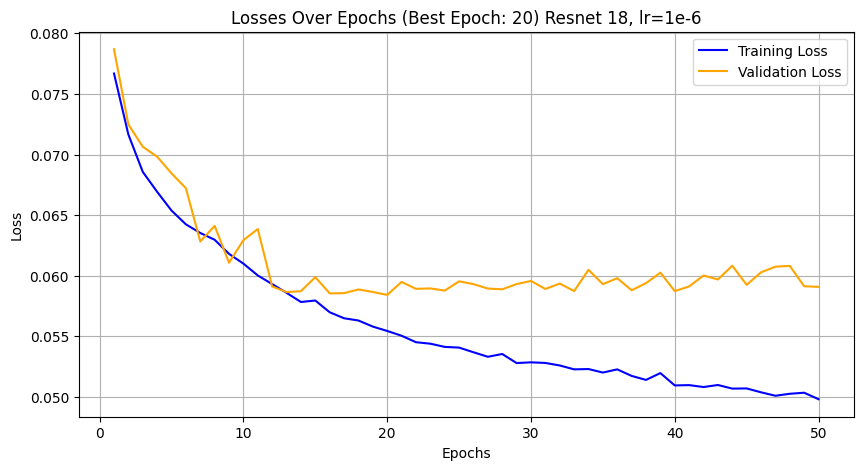

In [196]:
plot_losses(train_loss_6, validation_loss_6, best_epoch_6, title=" Resnet 18, lr=1e-6")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted Count: 9.90, GT Count: 14.54
Predicted Max pixel value: 9.902625
Predicted Min pixel value: 9.902625
GT Max pixel value: 0.017684886
GT Min pixel value: 0.0


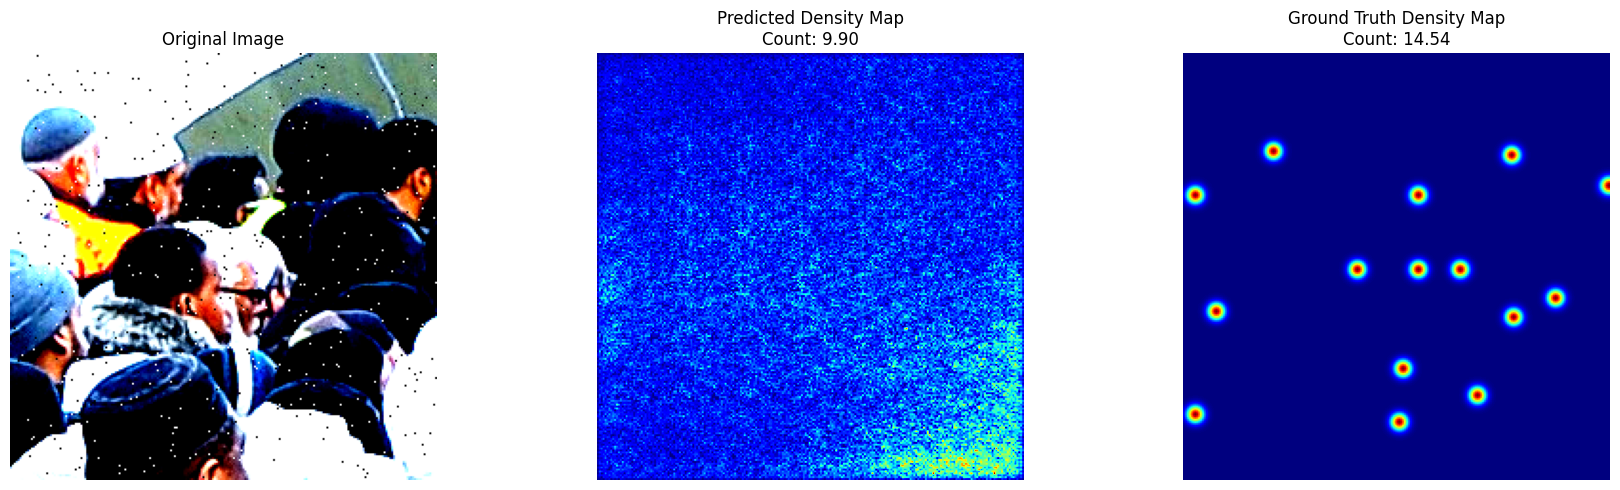

In [201]:
best_model_6 = CrowdCounterResNet()
best_model_6.load_state_dict(torch.load('ResNet18_1e-6.pth'))
best_model_6.to(device)
visualize_output(best_model_6, train_dataset, device=device, index=3)

Now we will try with resnet 34 backbone

In [203]:
resnet_34_3 = CrowdCounterResNet34Weights()
resnet_34_3, train_loss_34_3, validation_loss_34_3, best_epoch_34_3 = train_model(resnet_34_3, train_loader, val_loader, num_epochs=50, lr=1e-3, device=device, save_path='ResNet34_1e-3.pth')

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Adil/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:11<00:00, 7.89MB/s]


Epoch 1 Training Loss: 0.073099
Epoch 1 Validation Loss: 0.072969
Best model saved at epoch 1 with val loss 0.072969
Epoch 2 Training Loss: 0.070685
Epoch 2 Validation Loss: 0.073555
Epoch 3 Training Loss: 0.067950
Epoch 3 Validation Loss: 0.070056
Best model saved at epoch 3 with val loss 0.070056
Epoch 4 Training Loss: 0.068857
Epoch 4 Validation Loss: 0.087909
Epoch 5 Training Loss: 0.065422
Epoch 5 Validation Loss: 0.074678
Epoch 6 Training Loss: 0.063599
Epoch 6 Validation Loss: 0.093776
Epoch 7 Training Loss: 0.063281
Epoch 7 Validation Loss: 0.072862
Epoch 8 Training Loss: 0.061484
Epoch 8 Validation Loss: 0.062418
Best model saved at epoch 8 with val loss 0.062418
Epoch 9 Training Loss: 0.060159
Epoch 9 Validation Loss: 0.063303
Epoch 10 Training Loss: 0.059623
Epoch 10 Validation Loss: 0.060948
Best model saved at epoch 10 with val loss 0.060948
Epoch 11 Training Loss: 0.059770
Epoch 11 Validation Loss: 0.064237
Epoch 12 Training Loss: 0.060282
Epoch 12 Validation Loss: 0.0625

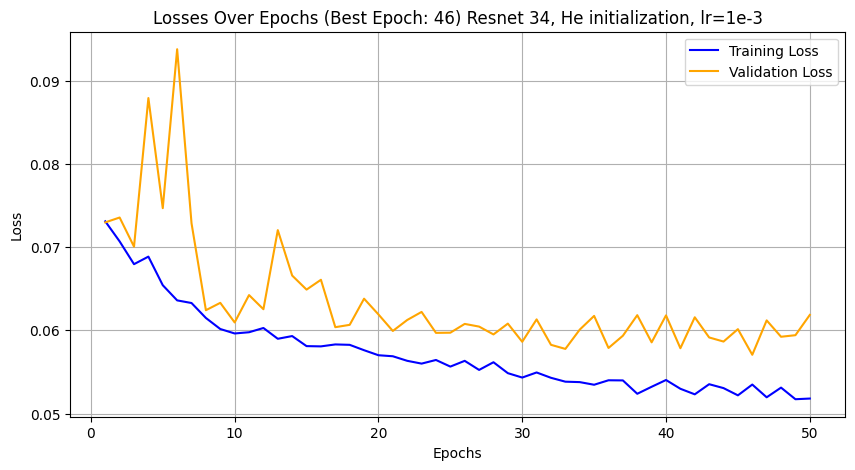

In [210]:
plot_losses(train_loss_34_3, validation_loss_34_3, best_epoch_34_3, title=" Resnet 34, He initialization, lr=1e-3")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted Count: 11.90, GT Count: 10.80
Predicted Max pixel value: 11.901118
Predicted Min pixel value: 11.901118
GT Max pixel value: 0.017684886
GT Min pixel value: 0.0


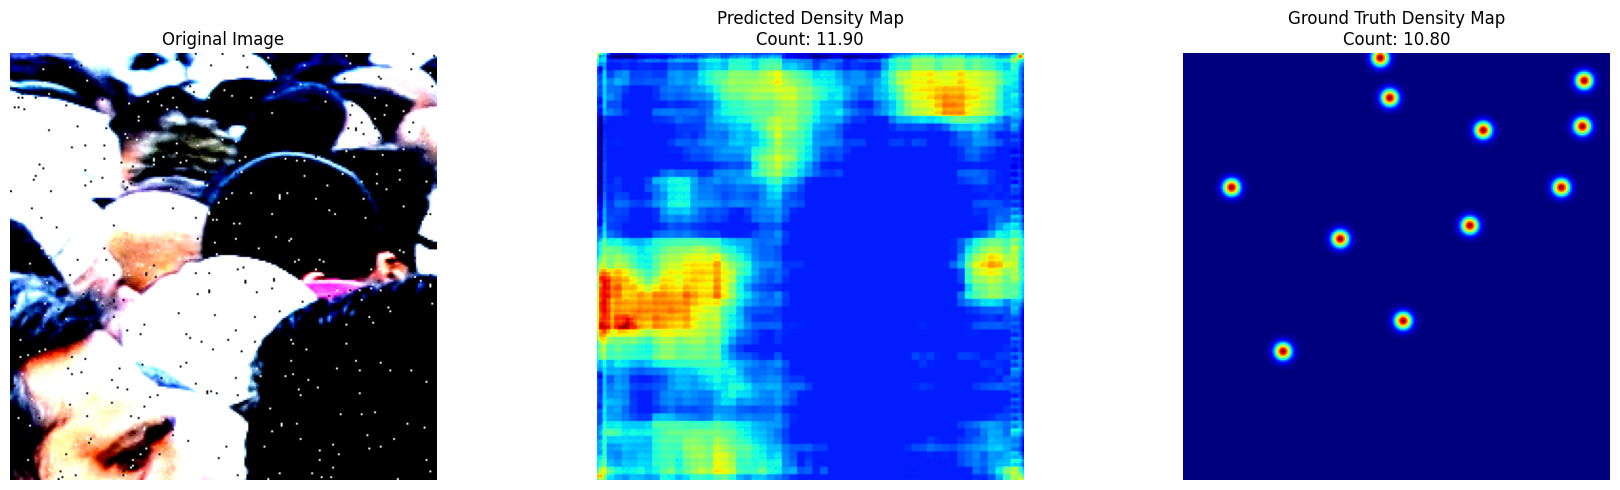

In [209]:
rs34_3 = CrowdCounterResNet34Weights()
rs34_3.load_state_dict(torch.load('ResNet34_1e-3.pth'))
rs34_3.to(device)
visualize_output(rs34_3, train_dataset, device=device, index=0)

In [211]:
resnet_34_4 = CrowdCounterResNet34Weights()
resnet_34_4, train_loss_34_4, validation_loss_34_4, best_epoch_34_4 = train_model(resnet_34_4, train_loader, val_loader, num_epochs=50, lr=1e-4, device=device, save_path='ResNet34_1e-4.pth')

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Training Loss: 0.064838
Epoch 1 Validation Loss: 0.061374
Best model saved at epoch 1 with val loss 0.061374
Epoch 2 Training Loss: 0.061409
Epoch 2 Validation Loss: 0.060053
Best model saved at epoch 2 with val loss 0.060053
Epoch 3 Training Loss: 0.056701
Epoch 3 Validation Loss: 0.064773
Epoch 4 Training Loss: 0.055263
Epoch 4 Validation Loss: 0.058745
Best model saved at epoch 4 with val loss 0.058745
Epoch 5 Training Loss: 0.053705
Epoch 5 Validation Loss: 0.057668
Best model saved at epoch 5 with val loss 0.057668
Epoch 6 Training Loss: 0.053717
Epoch 6 Validation Loss: 0.057423
Best model saved at epoch 6 with val loss 0.057423
Epoch 7 Training Loss: 0.051250
Epoch 7 Validation Loss: 0.057210
Best model saved at epoch 7 with val loss 0.057210
Epoch 8 Training Loss: 0.048700
Epoch 8 Validation Loss: 0.056233
Best model saved at epoch 8 with val loss 0.056233
Epoch 9 Training Loss: 0.048382
Epoch 9 Validation Loss: 0.058151
Epoch 10 Training Loss: 0.047646
Epoch 10 Validat

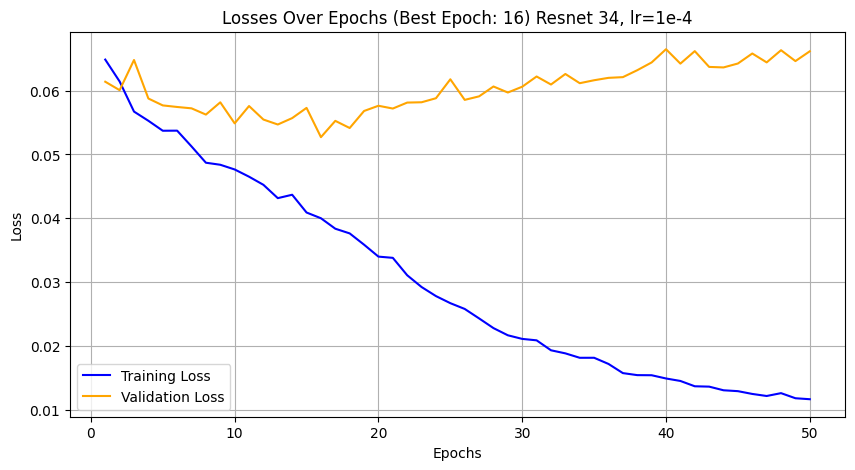

In [212]:
plot_losses(train_loss_34_4, validation_loss_34_4, best_epoch_34_4, title=" Resnet 34, lr=1e-4")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted Count: 11.52, GT Count: 14.54
Predicted Max pixel value: 11.523799
Predicted Min pixel value: 11.523799
GT Max pixel value: 0.017684886
GT Min pixel value: 0.0


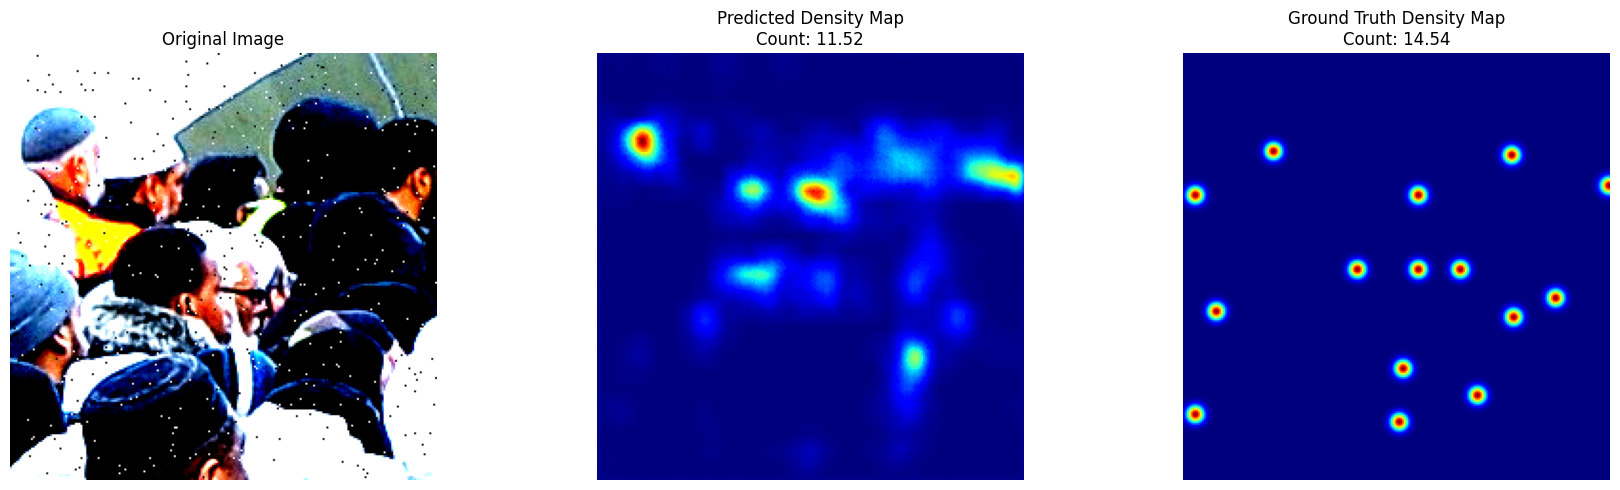

In [216]:
rs_34_4 = CrowdCounterResNet34Weights()
rs_34_4.load_state_dict(torch.load('ResNet34_1e-4.pth'))
rs_34_4.to(device)
visualize_output(rs_34_4, train_dataset, device=device, index=3)

In [217]:
resnet_34_5 = CrowdCounterResNet34Weights()
resnet_34_5, train_loss_34_5, validation_loss_34_5, best_epoch_34_5 = train_model(resnet_34_5, train_loader, val_loader, num_epochs=50, lr=1e-5, device=device, save_path='ResNet34_1e-5.pth')

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Training Loss: 0.067587
Epoch 1 Validation Loss: 0.063883
Best model saved at epoch 1 with val loss 0.063883
Epoch 2 Training Loss: 0.058749
Epoch 2 Validation Loss: 0.060767
Best model saved at epoch 2 with val loss 0.060767
Epoch 3 Training Loss: 0.055929
Epoch 3 Validation Loss: 0.062118
Epoch 4 Training Loss: 0.053871
Epoch 4 Validation Loss: 0.062467
Epoch 5 Training Loss: 0.052498
Epoch 5 Validation Loss: 0.058643
Best model saved at epoch 5 with val loss 0.058643
Epoch 6 Training Loss: 0.051639
Epoch 6 Validation Loss: 0.057270
Best model saved at epoch 6 with val loss 0.057270
Epoch 7 Training Loss: 0.050961
Epoch 7 Validation Loss: 0.058506
Epoch 8 Training Loss: 0.050442
Epoch 8 Validation Loss: 0.057384
Epoch 9 Training Loss: 0.049893
Epoch 9 Validation Loss: 0.058753
Epoch 10 Training Loss: 0.049314
Epoch 10 Validation Loss: 0.057065
Best model saved at epoch 10 with val loss 0.057065
Epoch 11 Training Loss: 0.047491
Epoch 11 Validation Loss: 0.056098
Best model sav

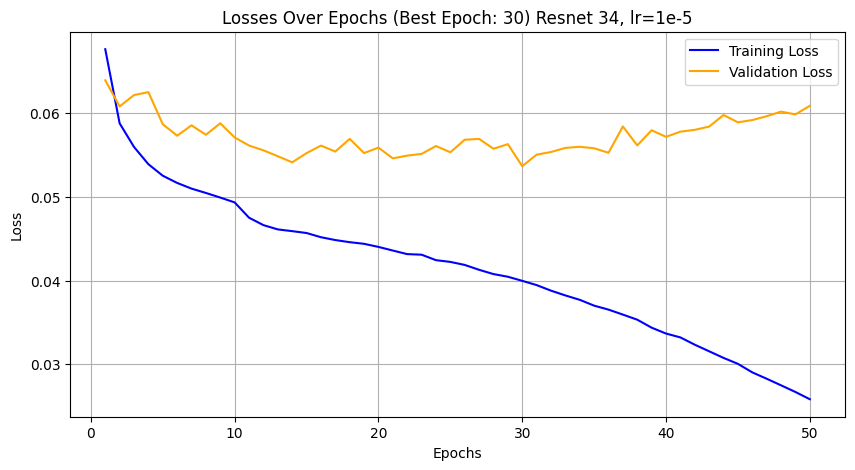

In [218]:
plot_losses(train_loss_34_5, validation_loss_34_5, best_epoch_34_5, title=" Resnet 34, lr=1e-5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted Count: 6.01, GT Count: 14.54
Predicted Max pixel value: 6.0108495
Predicted Min pixel value: 6.0108495
GT Max pixel value: 0.017684886
GT Min pixel value: 0.0


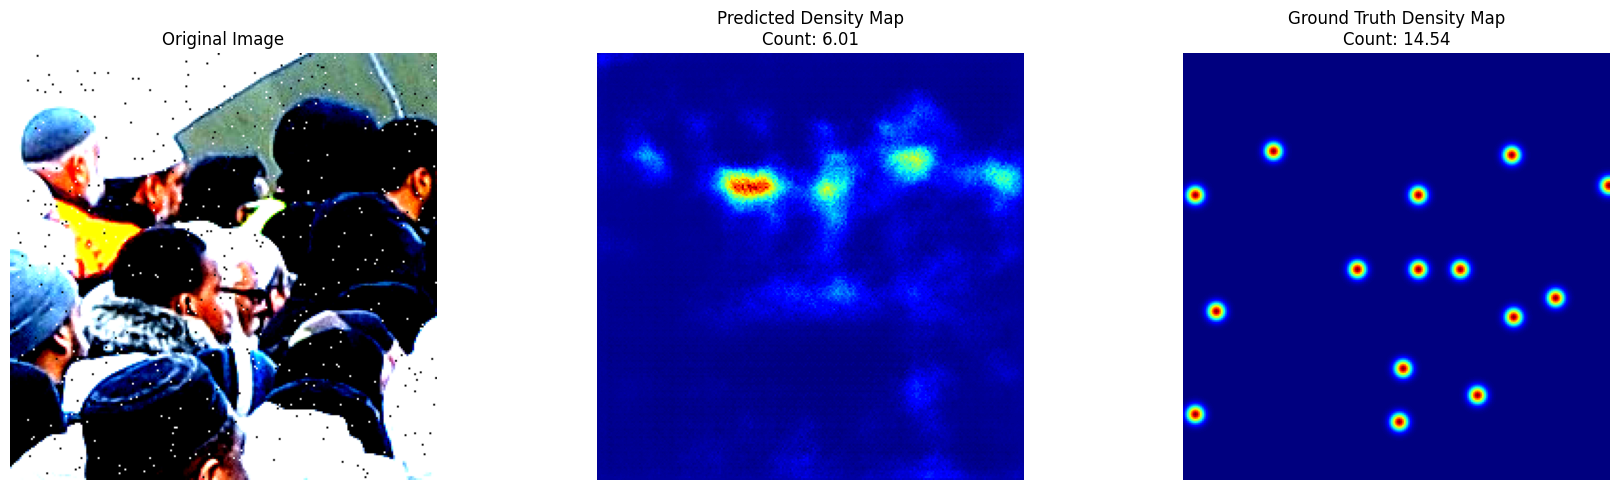

In [222]:
rs34_5 = CrowdCounterResNet34Weights()
rs34_5.load_state_dict(torch.load('ResNet34_1e-5.pth'))
rs34_5.to(device)
visualize_output(rs34_5, train_dataset, device=device, index=3)

In [223]:
resnet_34_6 = CrowdCounterResNet34Weights()
resnet_34_6, train_loss_34_6, validation_loss_34_6, best_epoch_34_6 = train_model(resnet_34_6, train_loader, val_loader, num_epochs=50, lr=1e-6, device=device, save_path='ResNet34_1e-6.pth')

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Training Loss: 0.076714
Epoch 1 Validation Loss: 0.078376
Best model saved at epoch 1 with val loss 0.078376
Epoch 2 Training Loss: 0.071598
Epoch 2 Validation Loss: 0.077457
Best model saved at epoch 2 with val loss 0.077457
Epoch 3 Training Loss: 0.068950
Epoch 3 Validation Loss: 0.071404
Best model saved at epoch 3 with val loss 0.071404
Epoch 4 Training Loss: 0.067495
Epoch 4 Validation Loss: 0.067409
Best model saved at epoch 4 with val loss 0.067409
Epoch 5 Training Loss: 0.066025
Epoch 5 Validation Loss: 0.066680
Best model saved at epoch 5 with val loss 0.066680
Epoch 6 Training Loss: 0.063826
Epoch 6 Validation Loss: 0.064349
Best model saved at epoch 6 with val loss 0.064349
Epoch 7 Training Loss: 0.062407
Epoch 7 Validation Loss: 0.065045
Epoch 8 Training Loss: 0.060730
Epoch 8 Validation Loss: 0.064003
Best model saved at epoch 8 with val loss 0.064003
Epoch 9 Training Loss: 0.059423
Epoch 9 Validation Loss: 0.061122
Best model saved at epoch 9 with val loss 0.06112

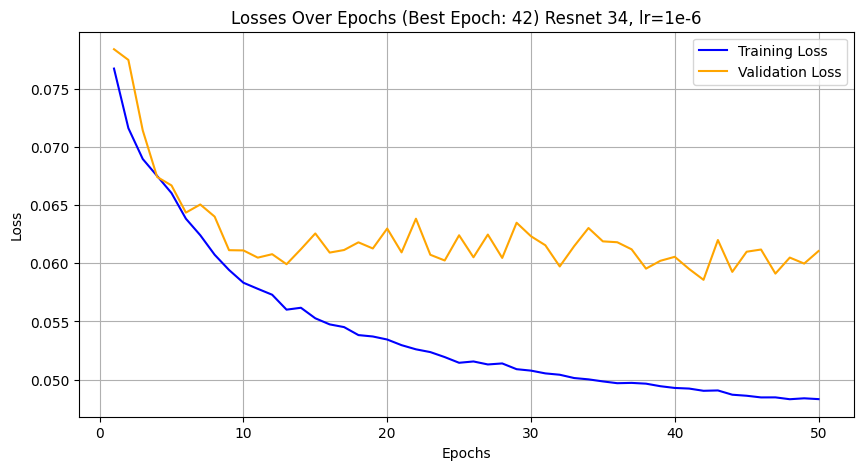

In [224]:
plot_losses(train_loss_34_6, validation_loss_34_6, best_epoch_34_6, title=" Resnet 34, lr=1e-6")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted Count: 9.87, GT Count: 14.54
Predicted Max pixel value: 9.874489
Predicted Min pixel value: 9.874489
GT Max pixel value: 0.017684886
GT Min pixel value: 0.0


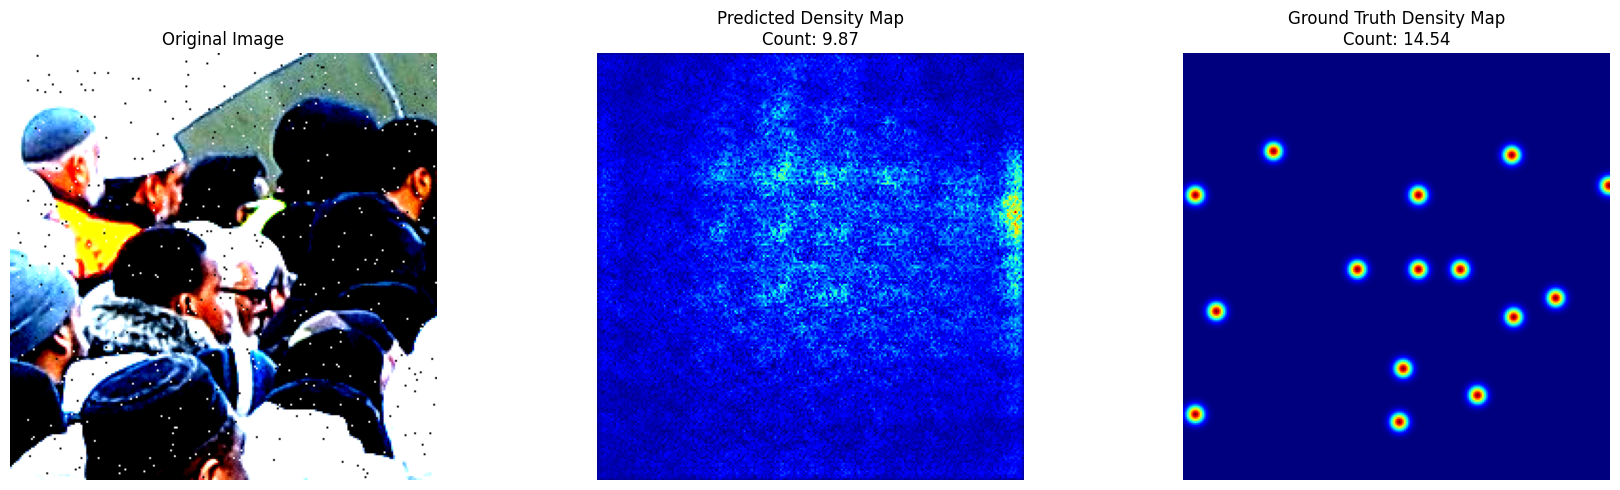

In [228]:
rs_34_6 = CrowdCounterResNet34Weights()
rs_34_6.load_state_dict(torch.load('ResNet34_1e-6.pth'))
rs_34_6.to(device)
visualize_output(rs_34_6, train_dataset, device=device, index=3)

Now we will try with ResNet-50 backbone

In [232]:
resnet_50_3 = CrowdCounterResNet50Weights()
resnet_50_3, train_loss_50_3, validation_loss_50_3, best_epoch_50_3 = train_model(resnet_50_3, train_loader, val_loader, num_epochs=3, lr=1e-5, device=device, save_path='ResNet50_1e-3.pth')

Epoch 1 Training Loss: 0.077383
Epoch 1 Validation Loss: 0.082272
Best model saved at epoch 1 with val loss 0.082272


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


Predicted Count: 35.31, GT Count: 8.00
Predicted Max pixel value: 35.31332
Predicted Min pixel value: 35.31332
GT Max pixel value: 0.017684886
GT Min pixel value: 0.0


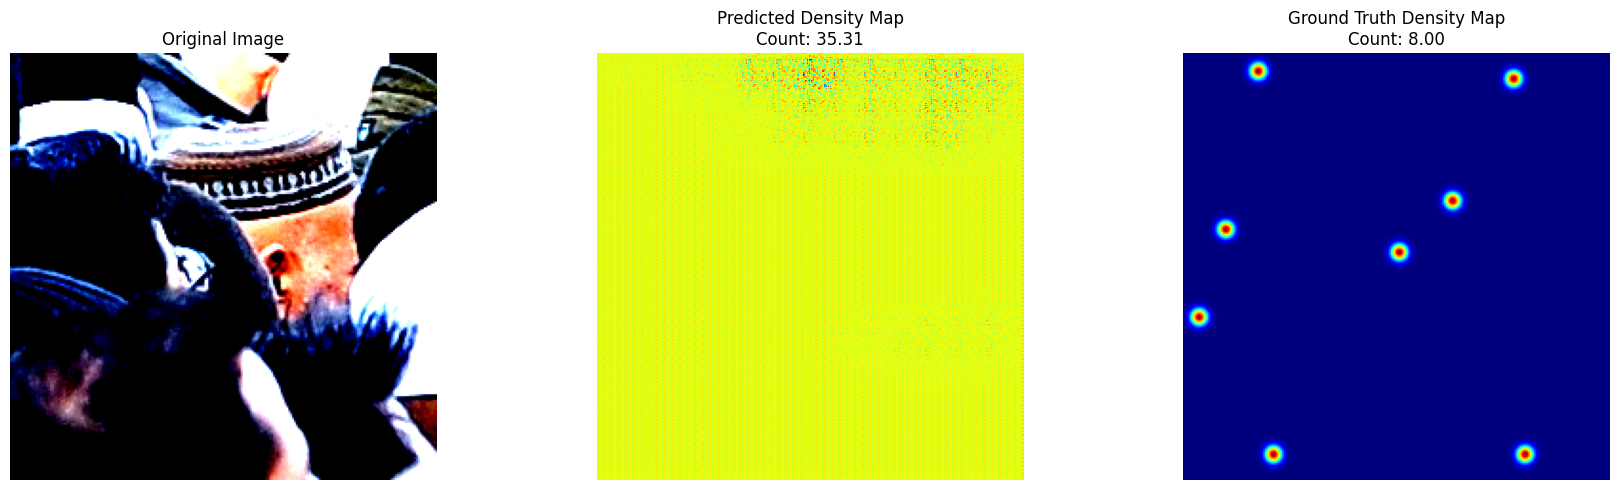

In [234]:
visualize_output(resnet_50_3, train_dataset, device=device, index=1)

In [237]:
test_resized_folder = "Test_resized_2"
test_density_folder = "Test_density_2"

test_image_paths = []
test_heatmap_paths = []

# Iterate over files in Train_resized folder
for file_name in os.listdir(test_resized_folder):
    if file_name.endswith(".jpg"):
        test_image_paths.append(os.path.join(test_resized_folder, file_name))

# Iterate over files in Train_density folder
for file_name in os.listdir(test_density_folder):
    if file_name.endswith(".npy"):
        test_heatmap_paths.append(os.path.join(test_density_folder, file_name))

print(f"Found {len(test_image_paths)} images and {len(test_heatmap_paths)} heatmaps.")

test_dataset = CrowdDataset(test_resized_folder, test_density_folder, test_image_paths)

Found 668 images and 668 heatmaps.


In [249]:
max_number = -1
min_number = float('inf')
summ = 0

for i in range(len(test_dataset)):
    image, target = test_dataset[i]
    target = target.squeeze().cpu().numpy()
    number = target.sum()

    if number > max_number:
        max_number = number
    if number < min_number:
        min_number = number

    summ += number

print("Statistics for test dataset:")
print(f"Max number of people in a single image: {max_number}")
print(f"Min number of people in a single image: {min_number}")
print(f"Average number of people in the dataset: {summ / len(test_dataset)}")

Statistics for test dataset:
Max number of people in a single image: 301.0126953125
Min number of people in a single image: 0.0
Average number of people in the dataset: 29.428558349609375


In [238]:
def compute_mae(model, dataset, device):
    scale_factor = 100
    summ = 0

    model.eval()

    for i in range(len(dataset)):
        image, gt_density = dataset[i]
        image = image.to(device).unsqueeze(0)
        gt_density = gt_density.squeeze().cpu().numpy()
        
        # Predict
        with torch.no_grad():
            output_scaled = model(image)
            # output = F.interpolate(output, size=(224, 224), mode='bilinear', align_corners=False)
            output_scaled = output_scaled.squeeze().cpu().numpy()

        # Count predictions
        output = output_scaled / scale_factor  # Scale back the output
        predicted_count = output.sum()
        gt_count = gt_density.sum()
        mae = np.abs(predicted_count - gt_count)
        summ += mae

    mae = summ / len(dataset)
    return mae

In [248]:
models_names = ['ResNet18_1e-3.pth', "ResNet18_1e-4.pth", "ResNet18_1e-5.pth", "ResNet18_1e-6.pth", 
          "ResNet34_1e-3.pth", "ResNet34_1e-4.pth", "ResNet34_1e-5.pth", "ResNet34_1e-6.pth"]

maes = {}

for i in models_names:
    if "18" in i:
        model = CrowdCounterResNetWeights()
        model.load_state_dict(torch.load(i))
        model.to(device)
        mae = compute_mae(model, test_dataset, device=device)

    elif "34" in i:
        model = CrowdCounterResNet34Weights()
        model.load_state_dict(torch.load(i))
        model.to(device)
        mae = compute_mae(model, test_dataset, device=device)

    print(f"MAE for {i}: {mae:.2f}")
    maes[i] = mae



c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MAE for ResNet18_1e-3.pth: 11.38
MAE for ResNet18_1e-4.pth: 10.06
MAE for ResNet18_1e-5.pth: 8.54
MAE for ResNet18_1e-6.pth: 10.78


c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MAE for ResNet34_1e-3.pth: 13.02
MAE for ResNet34_1e-4.pth: 8.51
MAE for ResNet34_1e-5.pth: 7.56
MAE for ResNet34_1e-6.pth: 8.55


We can see that ResNet-34 model with learning rate of 1e-5 has the best performance, let's visualize some examples

In [254]:
resnet_34_5 = CrowdCounterResNet34Weights()
resnet_34_5.load_state_dict(torch.load('ResNet34_1e-5.pth'))
resnet_34_5.to(device)

# for i in range(10):
#     visualize_output(resnet_34_5, test_dataset, device=device, index=i)

CrowdCounterResNet34Weights(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

Predicted Count: 2.04, GT Count: 1.00
Predicted Max pixel value: 2.037013
Predicted Min pixel value: 2.037013
GT Max pixel value: 0.017684886
GT Min pixel value: 0.0


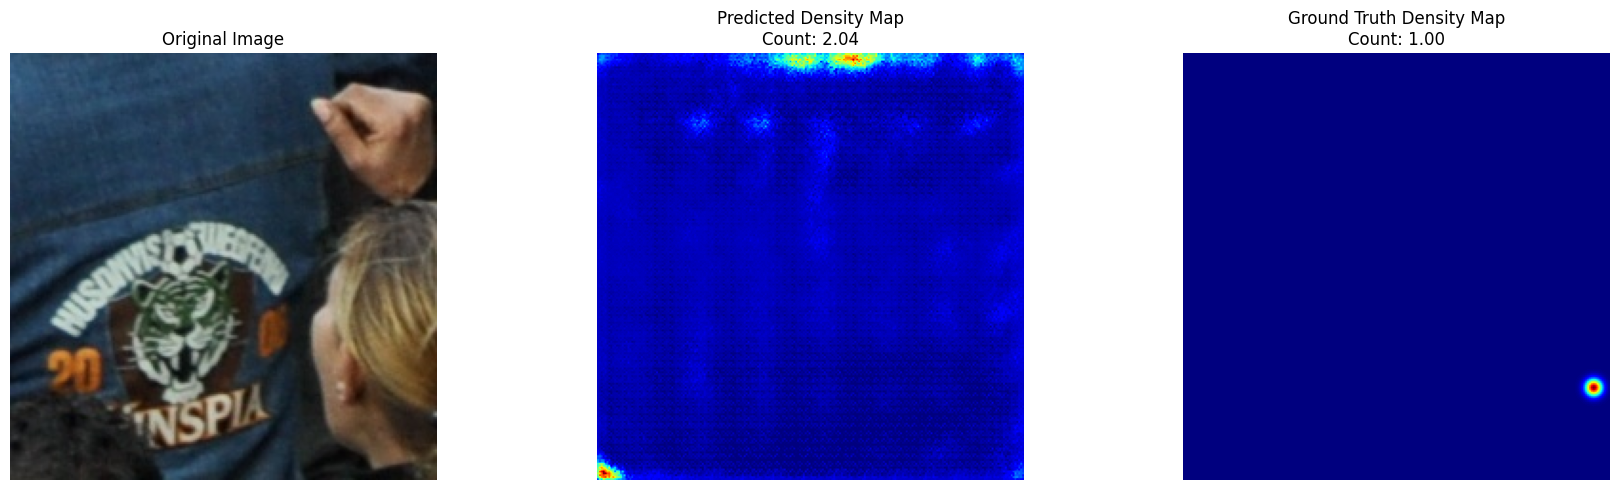

In [257]:
visualize_output(resnet_34_5, test_dataset, device=device, index=321)